In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg
import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp as smm
import statsmodels.tsa.stattools as tsa
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
#current_palette = sns.color_palette("hls", 8)
#sns.set_palette(current_palette)

In [3]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

In [4]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

# Separate into seasons
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')
seas_df = seasons.to_dataframe()
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

djf_df.reset_index(inplace=True)
jja_df.reset_index(inplace=True)
mam_df.reset_index(inplace=True)
son_df.reset_index(inplace=True)

del djf_df['index']
del jja_df['index']
del mam_df['index']
del son_df['index']

djf_df.columns = ['year', 'season', 'seaice_conc']
jja_df.columns = ['year', 'season', 'seaice_conc']
mam_df.columns = ['year', 'season', 'seaice_conc']
son_df.columns = ['year', 'season', 'seaice_conc']

del djf_df['season']
del jja_df['season']
del mam_df['season']
del son_df['season']

In [5]:
seasons = ['JJA', 'SON', 'DJF', 'MAM']
dfs = {'DJF': djf_df, 'JJA': jja_df, 'MAM': mam_df, 'SON': son_df}

In [6]:
cmap = {'JJA': 'crimson', 'SON': 'darkorange', 'DJF': 'steelblue', 'MAM': 'seagreen'}

## Arctic splines

Since the arctic sea data set is such a long time series, we'll compute linear splines to get a piecewise trend of the data.

#### Definitions:

* A **linear spline** is a continuous function formed by connecting linear
segments.  The points where the segments connect are called the
**knots** of the spline.

* A **spline of degree** $D$ is a function formed by connecting polynomial segments
of degree $D$ so that:
    * the function is continuous,
    * the function has $D-1$ continuous derivatives,
    * the $D^{\text{th}}$ derivative is constant between knots

* The **truncated polynomial** of degree $D$ associated with knot $\xi_{k}$ is the function which is equal to $0$ to the left of $\xi_{k}$ and equal to $(x-\xi_{k})^D$ to the right of $\xi_{k}$.

$$(x-\xi_{k})_{+}^D = 
\begin{cases}
(x-\xi_{k})^D, & \text{if $x \geq \xi_{k}$} \\
0, & \text{if $x \lt \xi_{k}$}
\end{cases}
$$


#### Equation of spline of degree $D$ and $K$ knots:

$$y = \beta_{0} + \sum_{d=1}^{D}\beta_{d}x_{d} + \sum_{k=1}^{K}\alpha_{k}(x-\xi_{k})_{+}^D$$

#### Design Matrix:
$$
\mathbf{X} = 
\begin{bmatrix}
1 & x_1 & x_{1}^{2} & \dots & x_{1}^{D} & (x_{1}-\xi_{1})_{+}^D & \dots & (x_{1}-\xi_{K})_{+}^D \\
1 & x_2 & x_{2}^{2} & \dots & x_{2}^{D} & (x_{2}-\xi_{1})_{+}^D & \dots & (x_{2}-\xi_{K})_{+}^D \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_{n}^{2} &\dots & x_{n}^{D} & (x_{n}-\xi_{1})_{+}^D & \dots & (x_{n}-\xi_{K})_{+}^D
\end{bmatrix}
$$

In [7]:
def linear_splines(data, knots, degree=1):
    minyr = data.year.min()
    nyrs = data.year.shape[0]

    # Use indices of years for knots
    minyr = data.year.min()
    knots2 = [k-minyr for k in knots]
    
    # Column vector for beta1 are (t1, t2,...,tn)
    X1 = np.arange(nyrs)
    X1 = X1[:, np.newaxis]
    
    # Generate design matrix
    X2 = np.zeros((nyrs, len(knots2)))
    for col, k in enumerate(knots2):
        X2[k:, col] = np.abs(X2[k:, col] - X1[:nyrs-k, 0])
    X = np.hstack((X1, X2))
    return smf.glm('seaice_conc ~ X', data=data).fit()

### Knots for Arctic sea

From the explore_seaice notebook, the trends look peicewise with possible knots at various locations. We'll define our set of knots for each season:

$$
K_{\text{JJA}} = \{1917, 1944, 1996\}\\
K_{\text{SON}} = \{1917, 1943, 1996\}\\
K_{\text{DJF}} = \{1974, 1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$

We'll plot the knots to visually check

In [8]:
# Define the knots
jjaknots = [1917, 1944, 1996]
#jjaknots2 = [1893, 1899, 1917, 1943, 1996]
sonknots = [1917, 1943, 1996]
djfknots = [1974, 1996]
mamknots = [1933, 1979]

splines = {'JJA': linear_splines(jja_df, jjaknots),
           'SON': linear_splines(son_df, sonknots),
           'DJF': linear_splines(djf_df, djfknots),
           'MAM': linear_splines(mam_df, mamknots)}

In [9]:
def plot_splines(yrs, conc, preds, label, season=None, ax=None, col='g'):
    if ax is None:
        ax = plt.gca()
    spl = ax.plot(yrs, conc, alpha=0.3, color='k')
    ax.plot(yrs, preds, label=label, color=col)
    ax.legend()
    ax.set_xlim(1845, 2016)
    #ax.set_ylim(17.5, 26)
    ax.set_xlabel('years')
    ax.set_ylabel('seaice_conc')
    ax.set_title('Linear Splines for {}'.format(season))
    return spl

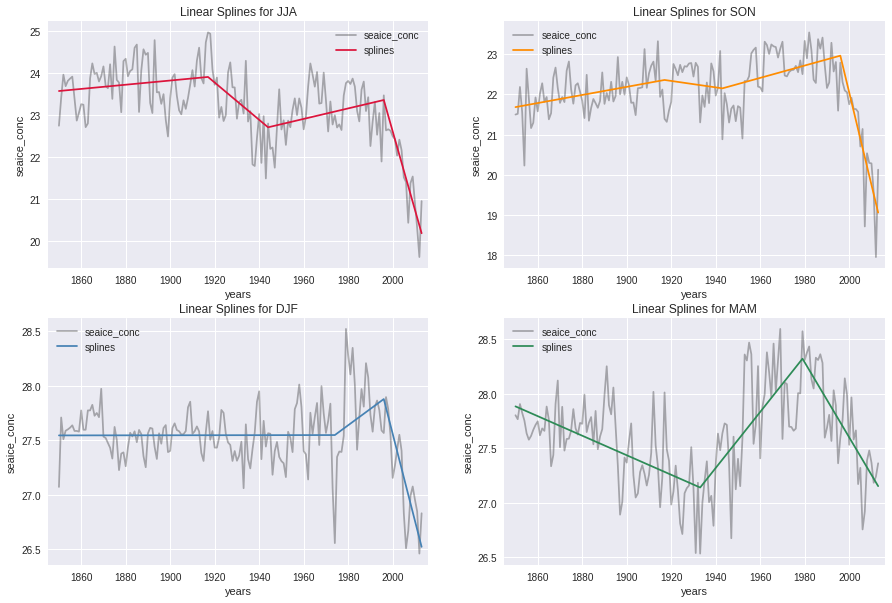

In [10]:
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

Visually the splines look reasonable. However, let's test the significance of each spline and remove the splines that are not significicant with a significance level, $\alpha = 0.05$

We'll use Bonferroni's correction for multiple tests.

In [11]:
nyrs = yr_avg.shape[0]
#nparams = len(knots) + 2

# Estimates
mu_hat = {season: spl.mu for season, spl in splines.items()}
R = {season: spl.resid_response.values for season, spl in splines.items()}
cov = {season: spl.cov_params() for season, spl in splines.items()}
#sigma_hat2 = {season: np.sum(r**2) / (nyrs-nparams) for season, r in R.items()}
pvals = {season: spl.pvalues.values for season, spl in splines.items()}

In [12]:
bonferonnis = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals.items()}

In [13]:
for season, test in bonferonnis.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True False  True  True  True]
SON: [ True  True False False  True]
DJF: [ True False  True  True]
MAM: [ True  True  True  True]


We see some splines are not significant. We'll remove those and recompute our model. Our new knots are now:

$$
K_{\text{JJA}} = \{1944, 1996\}\\
K_{\text{SON}} = \{1917, 1996\}\\
K_{\text{DJF}} = \{1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$


In [14]:
# Splines with new knots... Pt.2
jjaknots2 = [1944, 1996]
sonknots2 = [1917, 1996]
djfknots2 = [1996]
mamknots2 = [1933, 1979]

splines2 = {'JJA': linear_splines(jja_df, jjaknots2),
           'SON': linear_splines(son_df, sonknots2),
           'DJF': linear_splines(djf_df, djfknots2),
           'MAM': linear_splines(mam_df, mamknots2)}

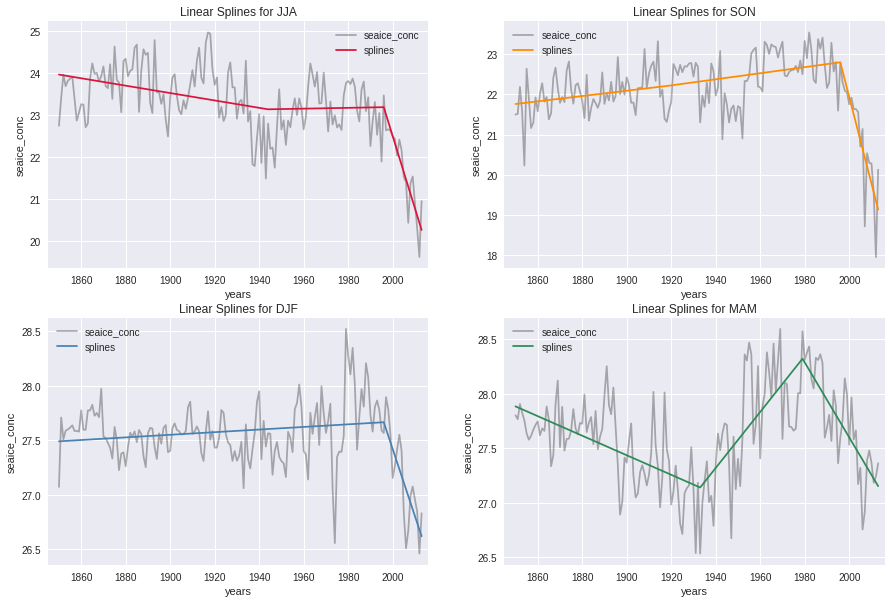

In [15]:
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines2[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

In [16]:
# Estimates Pt.2
mu_hat2 = {season: spl.mu for season, spl in splines2.items()}
R2 = {season: spl.resid_response.values for season, spl in splines2.items()}
cov2 = {season: spl.cov_params() for season, spl in splines2.items()}
pvals2 = {season: spl.pvalues.values for season, spl in splines2.items()}

bonferonnis2 = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals2.items()}

for season, test in bonferonnis2.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True  True False  True]
SON: [ True  True False  True]
DJF: [ True  True  True]
MAM: [ True  True  True  True]


Once again, we see some splines that don't make the cut. We'll remove those, and recompute our model. Our knots are now:

$$
K_{\text{JJA}} = \{1996\}\\
K_{\text{SON}} = \{1996\}\\
K_{\text{DJF}} = \{1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$


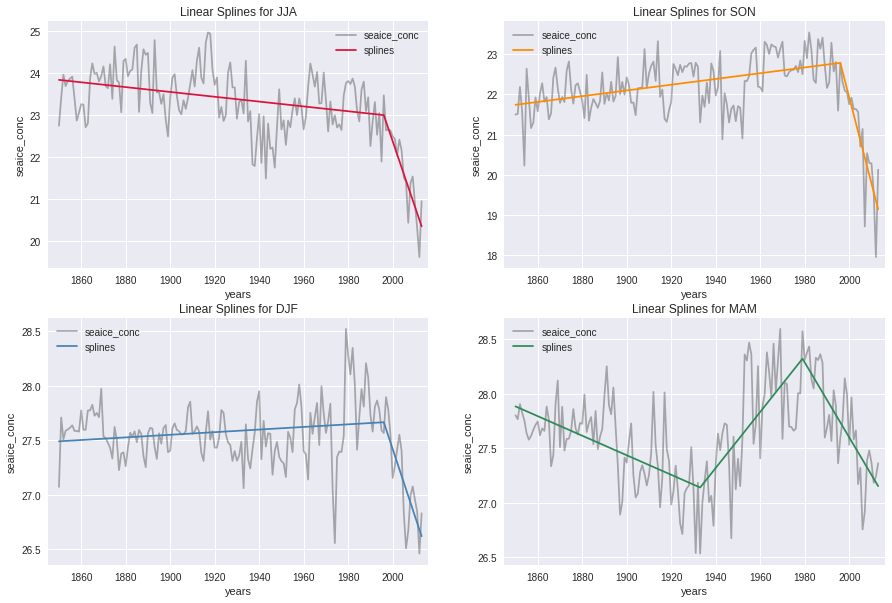

In [17]:
# Estimates Pt.3
jjaknots3 = [1996]
sonknots3 = [1996]
djfknots3 = [1996]
mamknots3 = [1933, 1979]

splines3 = {'JJA': linear_splines(jja_df, jjaknots3),
           'SON': linear_splines(son_df, sonknots3),
           'DJF': linear_splines(djf_df, djfknots3),
           'MAM': linear_splines(mam_df, mamknots3)}

f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines3[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

In [18]:
# Bonferonnis Pt.3
mu_hat3 = {season: spl.mu for season, spl in splines3.items()}
R3 = {season: spl.resid_response.values for season, spl in splines3.items()}
cov3 = {season: spl.cov_params() for season, spl in splines3.items()}
pvals3 = {season: spl.pvalues.values for season, spl in splines3.items()}

bonferonnis3 = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals3.items()}

for season, test in bonferonnis3.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True  True  True]
SON: [ True  True  True]
DJF: [ True  True  True]
MAM: [ True  True  True  True]


Finally! We have a set of knots that are significant.

In [19]:
# Rename R3 to something more meaningful: residuals
residuals = R3

### Plot ACFs and PACFs of the residiuals for each season

In [20]:
def plot_corr(acf_x, nlags, ax=None, title='Autocorrelation', **kwargs):
    def bonferroni_confint(x, alpha=0.05):
        nobs = len(x)
        confint = sp.stats.norm.ppf(1 - alpha/nobs) / np.sqrt(nobs)
        return confint, -confint
    
    confint = bonferroni_confint(acf_x)
    
    if ax is None:
        ax = plt.gca()
    fig = ax.stem(acf_x)
    plt.setp(fig[0], 'markersize', 0)
    ax.set_title(title)
    ax.set_ylim([min(acf_x)-0.3, 1])

    if confint is not None:
        ax.axhline(y=confint[0],xmin=0,xmax=nlags,c='black',linewidth=0.5,linestyle='--',zorder=0)
        ax.axhline(y=confint[1],xmin=0,xmax=nlags,c='black',linewidth=0.5,linestyle='--',zorder=0)
    return fig

In [21]:
def plot_acf(data, nlags, alpha=0.05, ax=None, title='Autocorrelation'):
    acf_x, _ = tsa.acf(data, nlags=nlags, alpha=alpha)
    return plot_corr(acf_x, nlags=nlags, ax=ax, title=title)

In [22]:
def plot_pacf(data, nlags, alpha=0.05, ax=None, title='Partial Autocorrelation'):
    method = 'ywm'
    pacf_x, _ = tsa.pacf(data, nlags=nlags, alpha=alpha, method=method)
    return plot_corr(pacf_x, nlags=nlags, ax=ax, title=title)

<Container object of 3 artists>

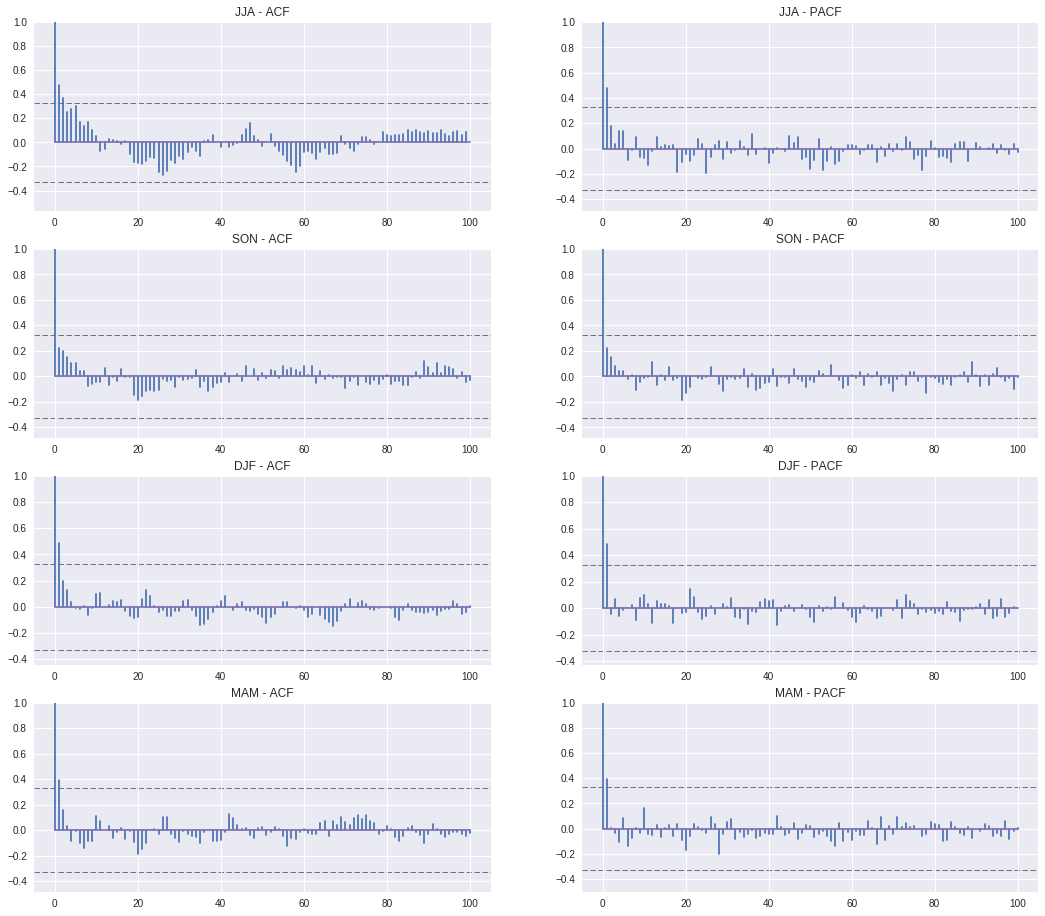

In [23]:
# Plot ACFs and PACFs
f, axs = plt.subplots(4, 2, figsize=(18,16))

plot_acf(residuals['JJA'], nlags=100, ax=axs[0,0], title='JJA - ACF')
plot_pacf(residuals['JJA'], nlags=100, ax=axs[0,1], title='JJA - PACF')

plot_acf(residuals['SON'], nlags=100, ax=axs[1,0], title='SON - ACF')
plot_pacf(residuals['SON'], nlags=100, ax=axs[1,1], title='SON - PACF')

plot_acf(residuals['DJF'], nlags=100, ax=axs[2,0], title='DJF - ACF')
plot_pacf(residuals['DJF'], nlags=100, ax=axs[2,1], title='DJF - PACF')

plot_acf(residuals['MAM'], nlags=100, ax=axs[3,0], title='MAM - ACF')
plot_pacf(residuals['MAM'], nlags=100, ax=axs[3,1], title='MAM - PACF')

In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

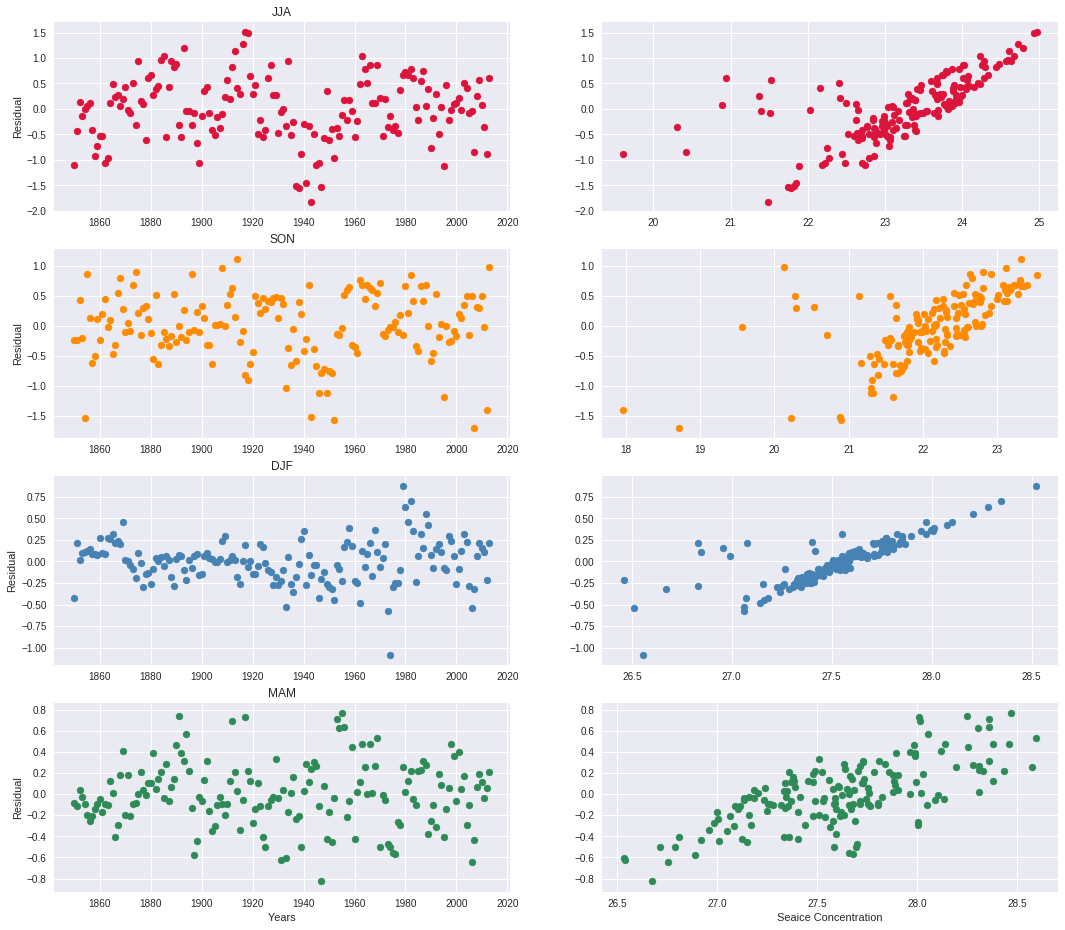

In [25]:
f, axr = plt.subplots(4, 2, figsize=(18,16))

axr[0,0].scatter(jja_df.year, residuals['JJA'], color=cmap['JJA'])
axr[0,0].set_ylabel('Residual')
axr[0,0].set_title('JJA')
axr[0,1].scatter(jja_df.seaice_conc, residuals['JJA'], color=cmap['JJA'])

axr[1,0].scatter(son_df.year, residuals['SON'], color=cmap['SON'])
axr[1,0].set_ylabel('Residual')
axr[1,0].set_title('SON')
axr[1,1].scatter(son_df.seaice_conc, residuals['SON'], color=cmap['SON'])

axr[2,0].scatter(djf_df.year, residuals['DJF'], color=cmap['DJF'])
axr[2,0].set_ylabel('Residual')
axr[2,0].set_title('DJF')
axr[2,1].scatter(djf_df.seaice_conc, residuals['DJF'], color=cmap['DJF'])

axr[3,0].scatter(mam_df.year, residuals['MAM'], color=cmap['MAM'])
axr[3,0].set_ylabel('Residual')
axr[3,0].set_title('MAM')
axr[3,1].scatter(mam_df.seaice_conc, residuals['MAM'], color=cmap['MAM'])

axr[3,0].set_xlabel('Years')
axr[3,1].set_xlabel('Seaice Concentration')

In [26]:
# Compute FFT of the residuals
# Take the periodogram (abs(R)^2)
# Plot the periodogram

In [27]:
ffts = {season: np.fft.fft(resid) for season, resid in residuals.items()}
periodograms = {season: np.abs(fftr)**2 for season, fftr in ffts.items()}

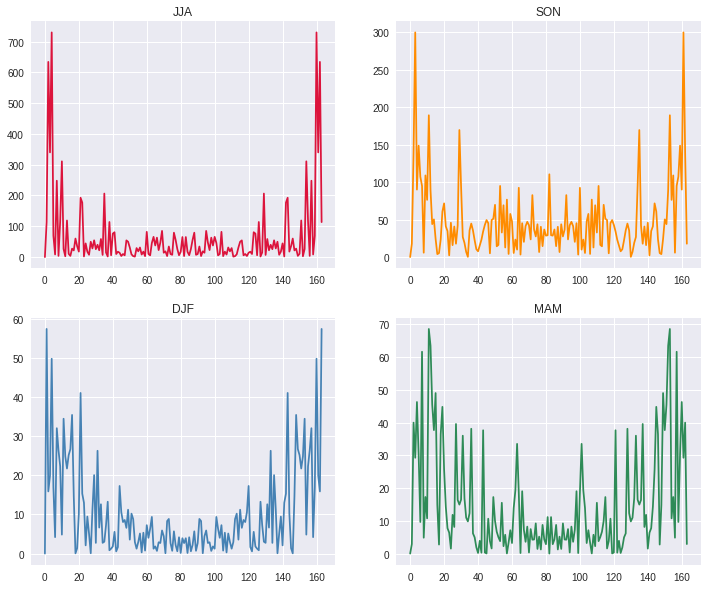

In [28]:
f, ax = plt.subplots(2, 2, figsize=(12,10))

ax[0,0].plot(periodograms['JJA'], color=cmap['JJA'])
ax[0,0].set_title('JJA')

ax[0,1].plot(periodograms['SON'], color=cmap['SON'])
ax[0,1].set_title('SON')

ax[1,0].plot(periodograms['DJF'], color=cmap['DJF'])
ax[1,0].set_title('DJF')

ax[1,1].plot(periodograms['MAM'], color=cmap['MAM'])
ax[1,1].set_title('MAM')

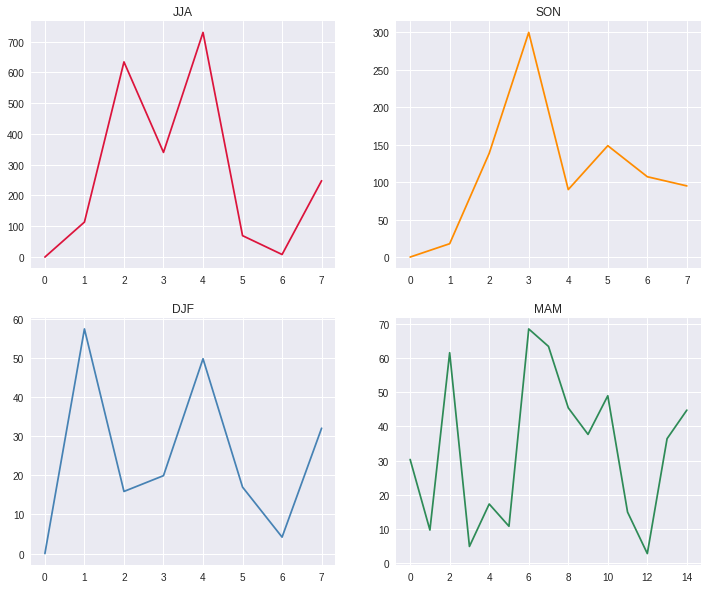

In [29]:
f, ax = plt.subplots(2, 2, figsize=(12,10))

ax[0,0].plot(periodograms['JJA'][:8], color=cmap['JJA'])
ax[0,0].set_title('JJA')

ax[0,1].plot(periodograms['SON'][:8], color=cmap['SON'])
ax[0,1].set_title('SON')

ax[1,0].plot(periodograms['DJF'][:8], color=cmap['DJF'])
ax[1,0].set_title('DJF')

ax[1,1].plot(periodograms['MAM'][5:20], color=cmap['MAM'])
ax[1,1].set_title('MAM')

In [30]:
t1 = yr_avg.year.values
nyrs = t1.max() - t1.min() + 1

# JJA

In [31]:
y_jja = jja_df.seaice_conc.values
sin_jja = np.array([np.sin(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])
cos_jja = np.array([np.cos(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])

In [32]:
fit_jja = smf.glm('y_jja ~ sin_jja + cos_jja', data=jja_df).fit()
fit_jja.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_jja   No. Observations:                  164
Model:                            GLM   Df Residuals:                      161
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                  0.712435913407
Method:                          IRLS   Log-Likelihood:                -203.39
Date:                Mon, 03 Jul 2017   Deviance:                       114.70
Time:                        14:34:22   Pearson chi2:                     115.
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     23.2248      0.066    352.371      0.000        23.096    23.354
sin_jja        0.0830      0.093      0.891      0.373        -0.100     0.266
cos_jja       -0.4711      0.093     -5.054      0.000        -0.654    -0.288
==============================================================================
"""

In [33]:
print(fit_jja.params)
k_hat_jja = fit_jja.params.values  # extract fitted regression coefficients
e_jja = fit_jja.resid_response    # extract raw residuals

Intercept    23.224777
sin_jja       0.083046
cos_jja      -0.471102
dtype: float64


In [34]:
# Check to see if the mean of residuals are numerically close to 0
print(np.mean(e_jja))

4.462554986785995e-15


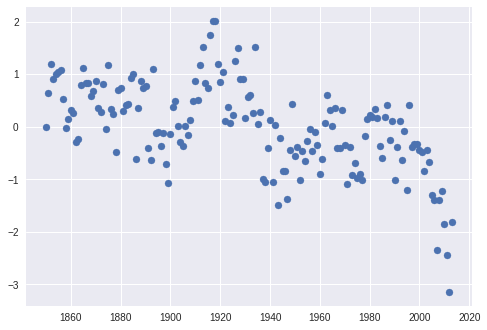

In [35]:
plt.scatter(jja_df.year, e_jja)

### Fit seasonal cycle with sine removed

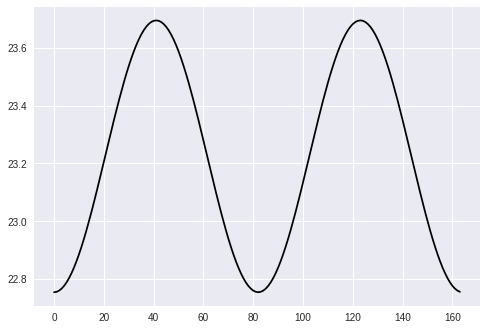

In [36]:
# fitted seasonal cycle
f_hat_jja = k_hat_jja[0] + k_hat_jja[2]*cos_jja  
plt.plot(f_hat_jja,'k-') 

In [37]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_jja = residuals['JJA'] - f_hat_jja
resid2_jja = resid2_jja - np.mean(resid2_jja)

In [38]:
import statsmodels.tsa.arima_model as arima

# Fit AR2 model for R^2
fit2_jja = arima.ARIMA(resid2_jja, (2,0,0)).fit()
fit2_jja.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(2, 0)   Log Likelihood                -130.861
Method:                       css-mle   S.D. of innovations              0.537
Date:                Mon, 03 Jul 2017   AIC                            269.722
Time:                        14:34:22   BIC                            282.121
Sample:                             0   HQIC                           274.755
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0027      0.097      0.027      0.978        -0.188     0.194
ar.L1.y        0.3971      0.078      5.080      0.000         0.244     0.550
ar.L2.y        0.1771      0.078      2.266      0.025         0.024     0.330
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5064           +0.0000j            1.5064            0.0000
AR.2           -3.7483           +0.0000j            3.7483            0.5000
-----------------------------------------------------------------------------
"""

In [39]:
# Remove fitted terms from residual (R^3) to check for white noise
resid3_jja = fit2_jja.resid
phi_hat_jja = fit2_jja.arparams

X1_jja = resid3_jja[1:]
X2_jja = resid3_jja[:-1]

X1_jja = X1_jja[:, np.newaxis]
X2_jja = X2_jja[:, np.newaxis]

X_jja = np.hstack((X1_jja, X2_jja))
E_jja = resid3_jja[1:] - np.dot(X_jja, phi_hat_jja)

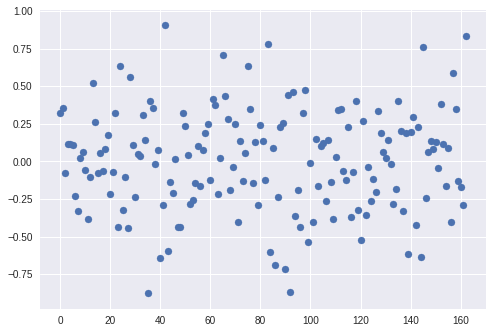

In [40]:
plt.scatter(np.arange(len(E_jja)), E_jja)

<Container object of 3 artists>

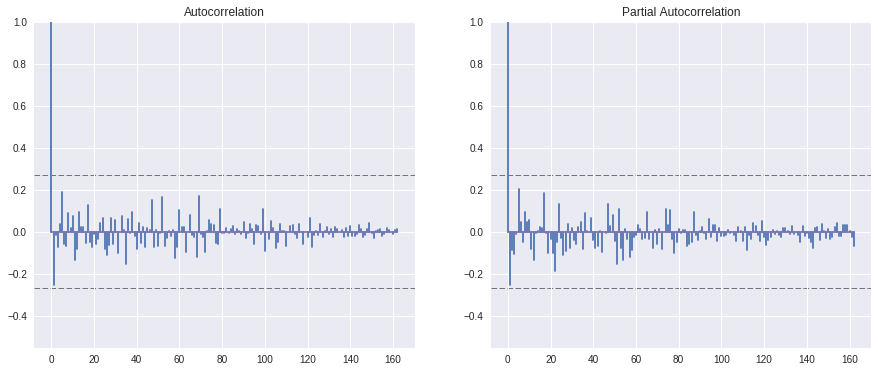

In [41]:
# Plot ACFs and PACFs
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))

plot_acf(E_jja, nlags=len(E_jja)-1, ax=ax1)
plot_pacf(E_jja, nlags=len(E_jja)-1, ax=ax2)

# SON

In [42]:
y_son = son_df.seaice_conc.values
sin_son = np.array([np.sin(2*np.pi*3 * (t/nyrs)) for t in np.arange(nyrs)])
cos_son = np.array([np.cos(2*np.pi*3 * (t/nyrs)) for t in np.arange(nyrs)])

In [43]:
fit_son = smf.glm('y_son ~ sin_son + cos_son', data=son_df).fit()
fit_son.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_son   No. Observations:                  164
Model:                            GLM   Df Residuals:                      161
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                  0.582065832471
Method:                          IRLS   Log-Likelihood:                -186.82
Date:                Mon, 03 Jul 2017   Deviance:                       93.713
Time:                        14:34:24   Pearson chi2:                     93.7
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     22.1133      0.060    371.185      0.000        21.997    22.230
sin_son        0.3285      0.084      3.899      0.000         0.163     0.494
cos_son       -0.3014      0.084     -3.577      0.000        -0.467    -0.136
==============================================================================
"""

In [44]:
# Check pvalues for coefficients
fit_son.pvalues

Intercept    0.000000
sin_son      0.000097
cos_son      0.000347
dtype: float64

In [45]:
print(fit_son.params)
k_hat_son = fit_son.params.values  # extract fitted regression coefficients
e_son = fit_son.resid_response    # extract raw residuals

Intercept    22.113337
sin_son       0.328516
cos_son      -0.301392
dtype: float64


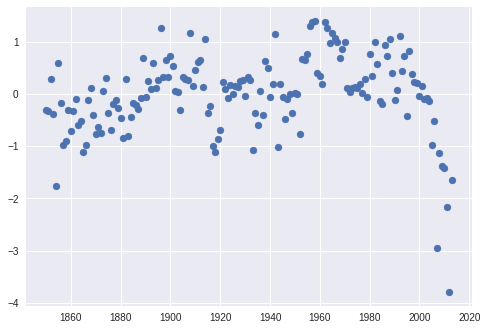

In [46]:
plt.scatter(son_df.year, e_son)

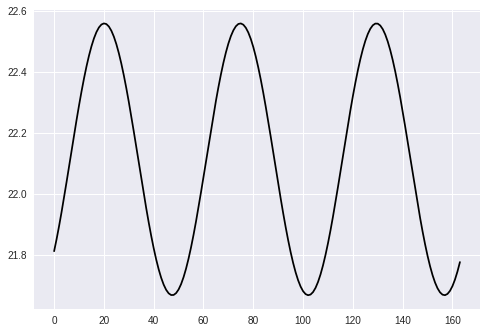

In [47]:
# fitted seasonal cycle
f_hat_son = k_hat_son[0] + k_hat_son[1]*sin_son + k_hat_son[2]*cos_son
plt.plot(f_hat_son,'k-')

In [48]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_son = residuals['SON'] - f_hat_son
resid2_son = resid2_son - np.mean(resid2_son)

In [49]:
# Fit AR2 model for R^2
fit2_son = arima.ARIMA(resid2_son, (2,0,0)).fit()
fit2_son.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(2, 0)   Log Likelihood                -128.666
Method:                       css-mle   S.D. of innovations              0.530
Date:                Mon, 03 Jul 2017   AIC                            265.332
Time:                        14:34:25   BIC                            277.732
Sample:                             0   HQIC                           270.366
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0040      0.071      0.056      0.956        -0.136     0.144
ar.L1.y        0.2214      0.078      2.824      0.005         0.068     0.375
ar.L2.y        0.2018      0.079      2.551      0.012         0.047     0.357
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7443           +0.0000j            1.7443            0.0000
AR.2           -2.8416           +0.0000j            2.8416            0.5000
-----------------------------------------------------------------------------
"""

In [50]:
# Remove fitted terms from residual (R^3) to check for white noise
resid3_son = fit2_son.resid
phi_hat_son = fit2_son.arparams

X1_son = resid3_son[1:]
X2_son = resid3_son[:-1]

X1_son = X1_son[:, np.newaxis]
X2_son = X2_son[:, np.newaxis]

X_son = np.hstack((X1_son, X2_son))
E_son = resid3_son[1:] - np.dot(X_son, phi_hat_son)

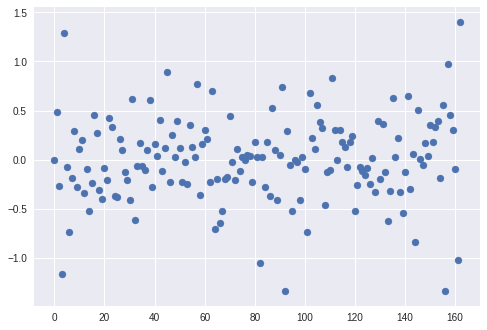

In [51]:
plt.scatter(np.arange(len(E_son)), E_son)

<Container object of 3 artists>

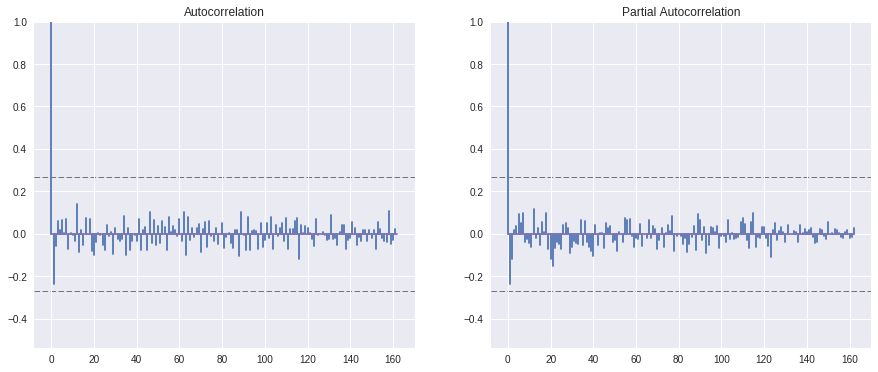

In [52]:
# Plot ACFs and PACFs
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))

plot_acf(E_son, nlags=len(E_son)-1, ax=ax1)
plot_pacf(E_son, nlags=len(E_son)-1, ax=ax2)

# DJF

In [53]:
y_djf = djf_df.seaice_conc.values
sin_djf = np.array([np.sin(2*np.pi*4 * (t/nyrs)) for t in np.arange(nyrs)])
cos_djf = np.array([np.cos(2*np.pi*4 * (t/nyrs)) for t in np.arange(nyrs)])

In [54]:
fit_djf = smf.glm('y_djf ~ sin_djf + cos_djf', data=djf_df).fit()
fit_djf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_djf   No. Observations:                  164
Model:                            GLM   Df Residuals:                      161
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                  0.081139469315
Method:                          IRLS   Log-Likelihood:                -25.242
Date:                Mon, 03 Jul 2017   Deviance:                       13.063
Time:                        14:34:26   Pearson chi2:                     13.1
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     27.5290      0.022   1237.648      0.000        27.485    27.573
sin_djf        0.1310      0.031      4.164      0.000         0.069     0.193
cos_djf       -0.1083      0.031     -3.444      0.001        -0.170    -0.047
==============================================================================
"""

In [55]:
# Check pvalues for coefficients
fit_djf.pvalues

Intercept    0.000000
sin_djf      0.000031
cos_djf      0.000573
dtype: float64

In [56]:
print(fit_djf.params)
k_hat_djf = fit_djf.params.values  # extract fitted regression coefficients
e_djf = fit_djf.resid_response    # extract raw residuals

Intercept    27.529046
sin_djf       0.130980
cos_djf      -0.108344
dtype: float64


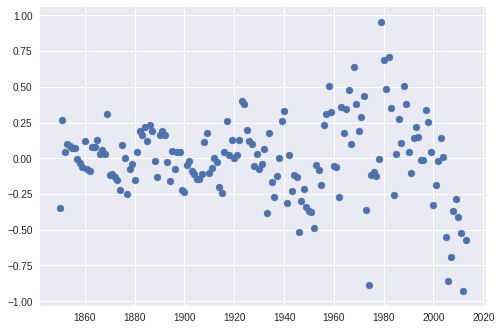

In [57]:
plt.scatter(djf_df.year, e_djf)

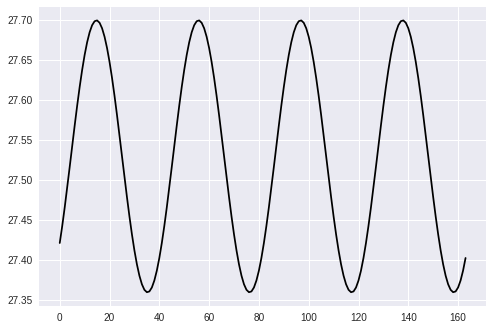

In [58]:
# fitted seasonal cycle
f_hat_djf = k_hat_djf[0] + k_hat_djf[1]*sin_djf + k_hat_djf[2]*cos_djf
plt.plot(f_hat_djf,'k-')

In [59]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_djf = residuals['DJF'] - f_hat_djf
resid2_djf = resid2_djf - np.mean(resid2_djf)

In [60]:
# Fit AR2 model for R^2
fit2_djf = arima.ARIMA(resid2_djf, (2,0,0)).fit()
fit2_djf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(2, 0)   Log Likelihood                  18.038
Method:                       css-mle   S.D. of innovations              0.217
Date:                Mon, 03 Jul 2017   AIC                            -28.076
Time:                        14:34:27   BIC                            -15.676
Sample:                             0   HQIC                           -23.042
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -2.593e-05      0.031     -0.001      0.999        -0.061     0.061
ar.L1.y        0.5267      0.079      6.626      0.000         0.371     0.683
ar.L2.y       -0.0664      0.080     -0.833      0.406        -0.223     0.090
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1431           +0.0000j            3.1431            0.0000
AR.2            4.7943           +0.0000j            4.7943            0.0000
-----------------------------------------------------------------------------
"""

In [61]:
# Remove fitted terms from residual (R^3) to check for white noise
resid3_djf = fit2_djf.resid
phi_hat_djf = fit2_djf.arparams

X1_djf = resid3_djf[1:]
X2_djf = resid3_djf[:-1]

X1_djf = X1_djf[:, np.newaxis]
X2_djf = X2_djf[:, np.newaxis]

X_djf = np.hstack((X1_djf, X2_djf))
E_djf = resid3_djf[1:] - np.dot(X_djf, phi_hat_djf)

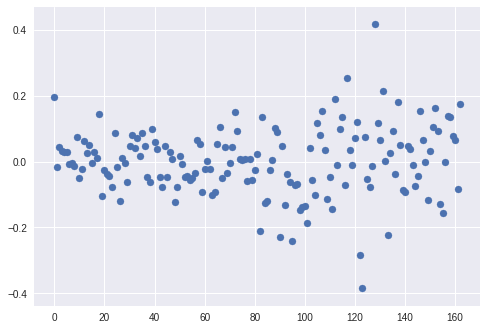

In [62]:
plt.scatter(np.arange(len(E_djf)), E_djf)

<Container object of 3 artists>

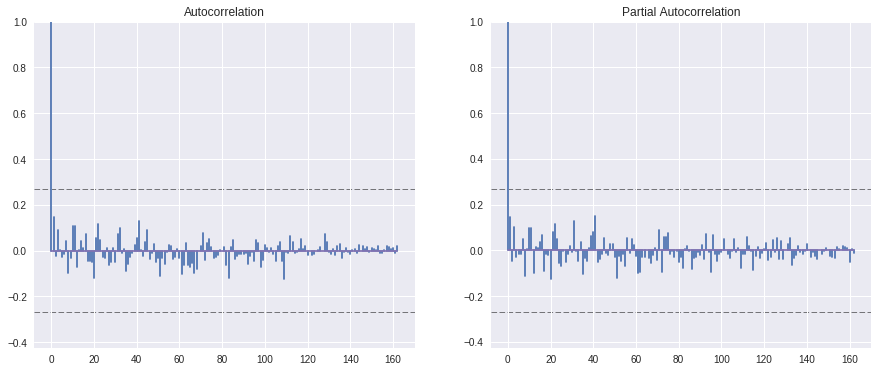

In [63]:
# Plot ACFs and PACFs
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))

plot_acf(E_djf, nlags=len(E_djf)-1, ax=ax1)
plot_pacf(E_djf, nlags=len(E_djf)-1, ax=ax2)

# MAM

In [64]:
y_mam = mam_df.seaice_conc.values
sin_mam = np.array([np.sin(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])
cos_mam = np.array([np.cos(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])

In [65]:
fit_mam = smf.glm('y_mam ~ sin_mam + cos_mam', data=mam_df).fit()
fit_mam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_mam   No. Observations:                  164
Model:                            GLM   Df Residuals:                      161
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                  0.137363237682
Method:                          IRLS   Log-Likelihood:                -68.412
Date:                Mon, 03 Jul 2017   Deviance:                       22.115
Time:                        14:34:28   Pearson chi2:                     22.1
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     27.6198      0.029    954.348      0.000        27.563    27.676
sin_mam        0.0907      0.041      2.216      0.027         0.010     0.171
cos_mam       -0.3030      0.041     -7.403      0.000        -0.383    -0.223
==============================================================================
"""

In [66]:
# Check pvalues for coefficients
fit_mam.pvalues

Intercept    0.000000e+00
sin_mam      2.671092e-02
cos_mam      1.330442e-13
dtype: float64

In [67]:
print(fit_mam.params)
k_hat_mam = fit_mam.params.values  # extract fitted regression coefficients
e_mam = fit_mam.resid_response    # extract raw residuals

Intercept    27.619764
sin_mam       0.090686
cos_mam      -0.302999
dtype: float64


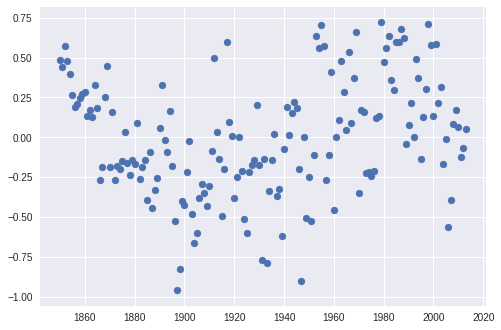

In [68]:
plt.scatter(mam_df.year, e_mam)

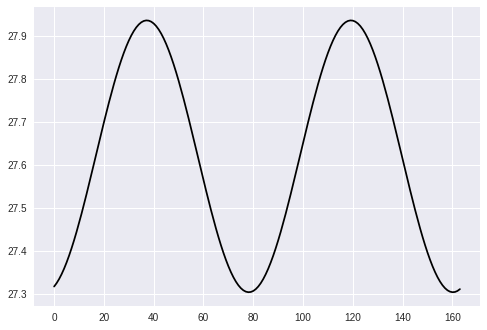

In [69]:
# fitted seasonal cycle
f_hat_mam = k_hat_mam[0] + k_hat_mam[1]*sin_mam + k_hat_mam[2]*cos_mam
plt.plot(f_hat_mam,'k-')

In [70]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_mam = residuals['MAM'] - f_hat_mam
resid2_mam = resid2_mam - np.mean(resid2_mam)

In [71]:
# Fit AR2 model for R^2
fit2_mam = arima.ARIMA(resid2_mam, (2,0,0)).fit()
fit2_mam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(2, 0)   Log Likelihood                 -30.509
Method:                       css-mle   S.D. of innovations              0.291
Date:                Mon, 03 Jul 2017   AIC                             69.018
Time:                        14:34:29   BIC                             81.417
Sample:                             0   HQIC                            74.052
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0064      0.052      0.124      0.902        -0.096     0.108
ar.L1.y        0.4825      0.078      6.201      0.000         0.330     0.635
ar.L2.y        0.0840      0.078      1.076      0.283        -0.069     0.237
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6174           +0.0000j            1.6174            0.0000
AR.2           -7.3632           +0.0000j            7.3632            0.5000
-----------------------------------------------------------------------------
"""

In [72]:
# Remove fitted terms from residual (R^3) to check for white noise
resid3_mam = fit2_mam.resid
phi_hat_mam = fit2_mam.arparams

X1_mam = resid3_mam[1:]
X2_mam = resid3_mam[:-1]

X1_mam = X1_mam[:, np.newaxis]
X2_mam = X2_mam[:, np.newaxis]

X_mam = np.hstack((X1_mam, X2_mam))
E_mam = resid3_mam[1:] - np.dot(X_mam, phi_hat_mam)

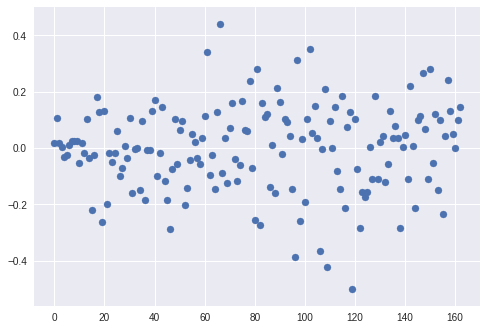

In [73]:
plt.scatter(np.arange(len(E_mam)), E_mam)

<Container object of 3 artists>

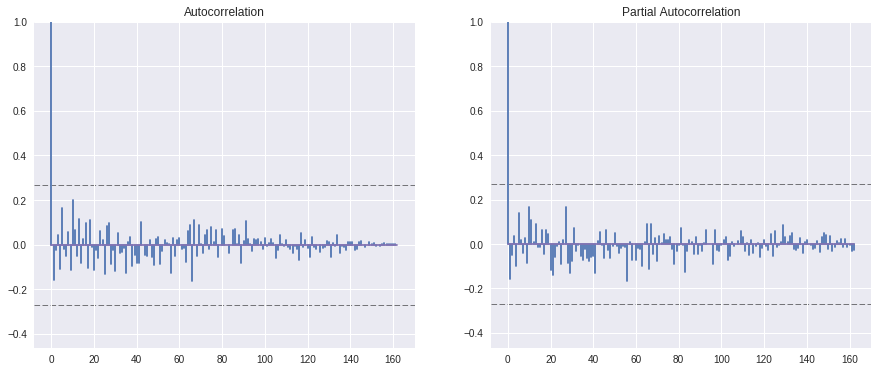

In [74]:
# Plot ACFs and PACFs
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))

plot_acf(E_mam, nlags=len(E_mam)-1, ax=ax1)
plot_pacf(E_mam, nlags=len(E_mam)-1, ax=ax2)